In [22]:
import matplotlib.pyplot as plt
import numpy as np
import sys, pathlib

# Project-1 folder (parent of this Notebooks/ folder)
proj_dir = pathlib.Path.cwd().parent
if str(proj_dir) not in sys.path:
    sys.path.insert(0, str(proj_dir))

# Figures folder
fig_dir = proj_dir / "Figures"
fig_dir.mkdir(parents=True, exist_ok=True)

from Code.data import make_data, build_features, split_and_scale

# --- Project-wide experiment config (used in ALL notebooks) ---

# Data settings
N_SAMPLES   = 300    # number of samples
NOISE_SD    = 0.3     # noise standard deviation
SEED_DATA   = 42      # data generation
SEED_SPLIT  = 42      # train/test split (split_and_scale uses this)
DEG_MAX     = 15      # max polynomial degree for features
P_FIXED     = 15  
TEST_SIZE   = 0.30    # train/test split size

# Regularization grids
LAM_GRID_RIDGE = np.logspace(-6, 1, 40)  # wider range for ridge
LAM_GRID_LASSO = np.logspace(-6, 0, 60)  # less range for LASSO

# Optimizer settings
ETA_FULL   = 5e-3     # full-batch GD steps
ITERS_FULL = 5000     # full-batch GD iterations
LAM_RIDGE  = 0.0203   # Taken from ridge experiments (02_Ridge_lambda.ipynb) best lambda for degree 15

# Mini-batch SGD
EPOCHS_MB    = 25     # passes over data
BATCH_SIZE   = 64     # minibatch size
ETA_MB_OLS   = 1e-2   # for OLS, can be larger
ETA_MB_RIDGE = 1e-2   # for ridge, need to tune
SEED_MB      = 42     # minibatch shuffle

# --- Generate data explicitly---
x, y = make_data(n=N_SAMPLES, noise_sd=NOISE_SD, seed=SEED_DATA)
X_full = build_features(x, degree=DEG_MAX, include_bias=False)


#X_tr_s, X_te_s, y_tr_c, y_te, scaler, y_mean = split_and_scale(X_full, y, test_size=TEST_SIZE, random_state=SEED_SPLIT)

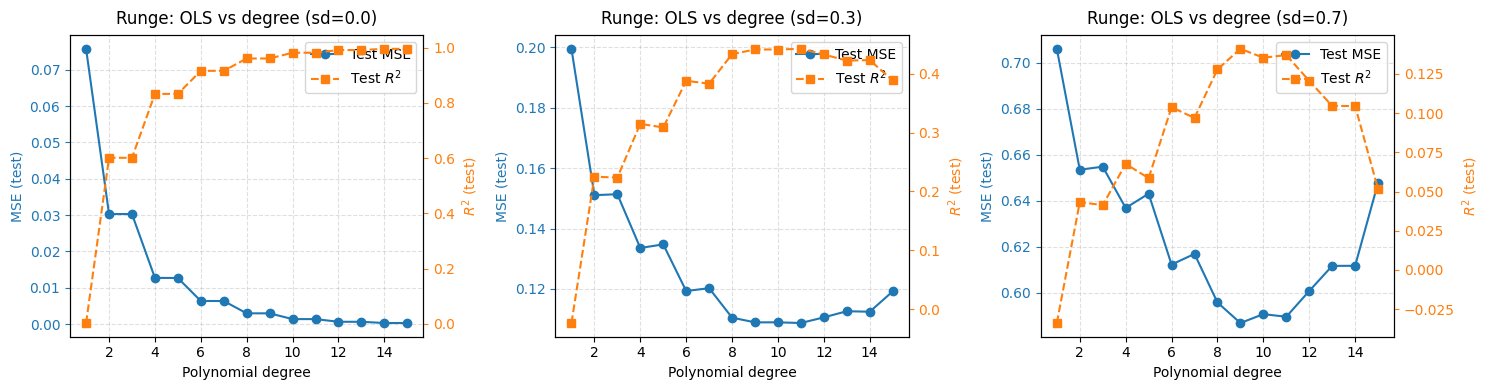

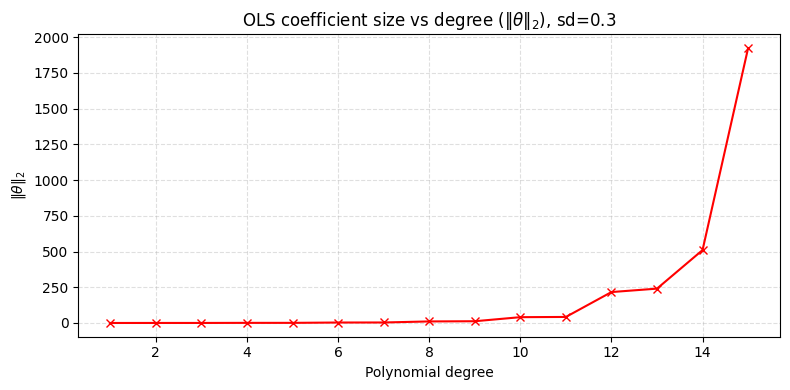

In [ ]:

from Code.data   import make_data, build_features, split_and_scale
from Code.models import sweep_degree
from Code.plots  import plot_mse_r2_vs_degree, plot_theta_norms

noise_sds  = [0.0, 0.3, 0.7]

# convenience so sweep_degree uses the same split each time
splitper = lambda X, Y: split_and_scale(X, Y, test_size=TEST_SIZE, random_state=SEED_SPLIT)

# --- Part (a): OLS vs degree for different noise levels (using sweep_degree) ---
fig, axes = plt.subplots(1, len(noise_sds), figsize=(5*len(noise_sds), 4), sharex=True)

for ax, sd in zip(axes, noise_sds):
    # regenerate data for THIS noise level
    x, y    = make_data(n=N_SAMPLES, noise_sd=sd, seed=SEED_DATA)
    X_full  = build_features(x, degree=DEG_MAX, include_bias=False)

    # sweep degrees (sweep_degree will call splitper internally)
    degrees, mse_deg, r2_deg, _ = sweep_degree(
        X_full, y, split_func=splitper, deg_max=DEG_MAX
    )

    # plot onto THIS axis
    plot_mse_r2_vs_degree(
        degrees, mse_deg, r2_deg,
        title=f"Runge: OLS vs degree (sd={sd})",
        ax=ax, show=False, savepath=None
    )

fig.tight_layout()
# fig.savefig(proj_dir / "Figures" / "runge_ols_mse_r2_subplots.png", dpi=300, bbox_inches="tight")
plt.show()

# --- coefficient norms vs degree ---
sd = 0.3
x, y   = make_data(n=N_SAMPLES, noise_sd=sd, seed=SEED_DATA)
X_full = build_features(x, degree=DEG_MAX, include_bias=False)
degrees, _, _, norms_deg = sweep_degree(X_full, y, split_func=splitper, deg_max=DEG_MAX)

plot_theta_norms(
    degrees, norms_deg,
    xlabel="Polynomial degree",
    title=r"OLS coefficient size vs degree ($\|\theta\|_2$), sd=0.3",
    savepath=None  # or proj_dir / "Figures" / "runge_ols_theta_norms_vs_degree.png"
)
